# Models

In [1]:
!pip install torchsummary
!pip install neptune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 92.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.2 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67673 sha256=917c68fded9adee6504933380b3baea42beb08261a47504d31e0cac0921cb807
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44ec4c358db21a5d63ed4e40f0f0012a438106f220bce4ccba
Successfully built bravado-core
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.131
    Uninstalling botocore-1.34.131:
      Successfully uninstalled botocore-1.34.131
  Attempting uninstall: s3transfer
    Found existing installation: s3trans

## Importing neccesary modules and define model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat((x, skip), dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = Encoder(in_channels, 64)
        self.enc2 = Encoder(64, 128)
        self.enc3 = Encoder(128, 256)
        self.enc4 = Encoder(256, 512)
        
        self.bottleneck = ConvBlock(512, 1024)
        
        self.dec1 = Decoder(1024, 512)
        self.dec2 = Decoder(512, 256)
        self.dec3 = Decoder(256, 128)
        self.dec4 = Decoder(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        skip1, enc1 = self.enc1(x)
        skip2, enc2 = self.enc2(enc1)
        skip3, enc3 = self.enc3(enc2)
        skip4, enc4 = self.enc4(enc3)
        
        bottleneck = self.bottleneck(enc4)
        
        dec1 = self.dec1(bottleneck, skip4)
        dec2 = self.dec2(dec1, skip3)
        dec3 = self.dec3(dec2, skip2)
        dec4 = self.dec4(dec3, skip1)
        
        out = torch.sigmoid(self.final_conv(dec4))
        return out

# Instantiate and summarize the model
model = UNet(in_channels=1, out_channels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
       BatchNorm2d-2         [-1, 64, 256, 256]             128
            Conv2d-3         [-1, 64, 256, 256]          36,928
       BatchNorm2d-4         [-1, 64, 256, 256]             128
         ConvBlock-5         [-1, 64, 256, 256]               0
         MaxPool2d-6         [-1, 64, 128, 128]               0
           Encoder-7  [[-1, 64, 256, 256], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
           Conv2d-10        [-1, 128, 128, 128]         147,584
      BatchNorm2d-11        [-1, 128, 128, 128]             256
        ConvBlock-12        [-1, 128, 128, 128]               0
        MaxPool2d-13          [-1, 128, 64, 64]               0
          Encoder-14  [[

### Loading the directories of input image and target masks and checking their validities.

### Code to verify if the input directory exists

In [3]:

import os
dirnum = 3 # Which dataset to be processed you can mention here
#parent_main_dir = f"/media/vinayak-amd/Backup/Home/KKS_Dataset/27808_1_{dirnum}" # Local machine
#parent_main_dir = f"/kaggle/input/27808_1_{dirnum}_cropped"  # Cloud notebook define the input directory
parent_main_dir = f"/kaggle/input/27808-1-3-tweezer-6000-images/27808_1_3_expanded_dataset/"
if os.path.exists(parent_main_dir):
    print("File path exists")
else:
    print("File path does not exist")

File path exists


### Defining the input and the output directories

In [4]:
import os
import cv2
import numpy as np
import glob

input_size = 256 ## Defining the dimension of the image...
img_size = input_size
target_size = (input_size, input_size)  # replace with your target size

# Get list of all files in input directory
input_img_paths_original= glob.glob(os.path.join(parent_main_dir,'cropped_images', '*.tif'))

# Get list of all files in mask directory
target_img_paths_original = glob.glob(os.path.join(parent_main_dir,'cropped_masks','*.tif'))


### Check the validty of filepaths and sort them alphabetically.

In [5]:
assert len(input_img_paths_original)>0, "No file found"
assert len(target_img_paths_original)>0, "No file found"
input_img_paths_original.sort()
target_img_paths_original.sort()

## Create a dataloader along with the batching ...

### Select a random fileset and visualize the images

- Here we select a random dataset( file source)  from the original files and then use those directory names to 


In [6]:
import random
selection_sample_size = 5000
random_subset = random.sample(list(zip(input_img_paths_original, target_img_paths_original)), selection_sample_size)
input_img_paths, target_img_paths = zip(*random_subset)  # Unpack the zipped folders

In [7]:
assert len(target_img_paths) == selection_sample_size, "Invalid files input, files not loaded properly" # To check if all the files have succesfully loaded, actual file size should be 18866

In [8]:
assert input_img_paths[0].split('/')[-1][4:9] == target_img_paths[0].split('/')[-1][3:8], "Images not sorted in the file list"

In [39]:
#!rm -r /kaggle/working/checkpoints

# DataLoaders

### Loading neccesary modules for the Dataloaders 

In [9]:
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch

## Dataloader for the Tweeezer Dataset

In [10]:
class TweezerSegDataset(Dataset):
    """Helper to iterate over the data (as Numneptune
py arrays)."""
    
    def __init__(self, img_size, input_img_paths, target_img_paths, transform=None):
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.transform = transform

    def __len__(self):
        return len(self.target_img_paths)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        input_img_path = self.input_img_paths[idx]
        target_img_path = self.target_img_paths[idx]
        
        minY, maxY = 0, -1  # Rows
        minX, maxX = 0, -1  # Columns
        resized_size_dimensions = (self.img_size, self.img_size)
        
        # Load and preprocess the input image
        img = cv2.imread(input_img_path)
        img_cropped = img[minY:maxY, minX:maxX]
        img_resized = cv2.resize(img_cropped, resized_size_dimensions)
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        normalized_img = cv2.normalize(img_gray, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        # Load and preprocess the target image (mask)
        mask = cv2.imread(target_img_path, cv2.IMREAD_GRAYSCALE)
        mask_cropped = mask[minY:maxY, minX:maxX]
        mask_resized = cv2.resize(mask_cropped, resized_size_dimensions)
        _, binary_mask = cv2.threshold(mask_resized, 0.1, 1.0, cv2.THRESH_BINARY)
        
        # Apply any additional transformations if specified
        if self.transform:
            normalized_img = self.transform(normalized_img)
            binary_mask = self.transform(binary_mask)
        
        # Convert to PyTorch tensors
        x = torch.tensor(normalized_img, dtype=torch.float32).unsqueeze(0)#permute(2, 0, 1)
        y = torch.tensor(binary_mask, dtype=torch.float32).unsqueeze(0)
        
        return x, y

## Create the train set, test set and val set dataset gen in order to train the model..

In [11]:
## Parameters for loading the images

#For folder 27808_1_1 
#minY = 3; # Rows
#maxY = 689
#minX = 398 # Columns
#maxX = 1020

# For already cropped image like 27808_1_3

minY = 0# Rows
maxY = -1
minX = 0 # Columns
maxX = -1


resized_size_dimensions = (input_size, input_size) #Resized size dimensions
cropping_img_dimensions = [minX, maxX, minY, maxY]

In [12]:
# Load an image
def load_img_pytorch(img_path):
    return Image.open(img_path)

In [13]:
# # Example usage
# img_path = "/kaggle/input/tweezer-03-final-v1/27808_1_3_cropped/images/Img000000_cropped.tiff"  # Replace with your image path
# img = load_img_pytorch(img_path)

# # Display the image
# plt.imshow(img, cmap='gray')
# plt.axis('off')
# plt.show()

In [14]:
import numpy as np
def normimg(img):

    img = cv2.resize(img, dsize=(input_size, input_size), interpolation=cv2.INTER_LINEAR)
    img =  (img - np.min(img))/(np.max(img) - np.min(img))
    return img


    """
    Converts a uint16 image to a normalized float image.
    Args:
    image: A numpy array representing the uint16 image.
    Returns:
    A numpy array representing the normalized float image.
    """
    # Check if the input is a uint16 image
    #if not image.dtype == p.uint16:
    #    raise ValueError("Input image must be of type uint16.")
    # Normalize the image to the range [0, 1]

In [15]:
num_classes = 1
batch_size = 8

## Create the dataset instances

#### Using skilearn to split the input and target file paths
- Split ratio 80, 10, 10 ( train, test, val) they are mapped one on one. 
- Using skilearn to split the images 
- Verify the splits after executing the operation

#### Import neccesary module from sklearn

In [16]:
from sklearn.model_selection import train_test_split

#### Split the data

In [17]:
# Split into training and remaining (validation + test)
train_input_img_paths, remaining_input_img_paths, train_target_img_paths, remaining_target_img_paths = train_test_split(
    input_img_paths, target_img_paths, test_size=0.2, random_state=42)

# Split remaining into validation and test
val_input_img_paths, test_input_img_paths, val_target_img_paths, test_target_img_paths = train_test_split(
    remaining_input_img_paths, remaining_target_img_paths, test_size=0.5, random_state=42)

#### Verify the split

In [18]:
print(f"Training set size: {len(train_input_img_paths)}")
print(f"Validation set size: {len(val_input_img_paths)}")
print(f"Test set size: {len(test_input_img_paths)}")

Training set size: 4000
Validation set size: 500
Test set size: 500


##### Create dataset instances

In [19]:
train_dataset = TweezerSegDataset(img_size, train_input_img_paths, train_target_img_paths)
val_dataset = TweezerSegDataset(img_size, val_input_img_paths, val_target_img_paths)
test_dataset = TweezerSegDataset(img_size, test_input_img_paths, test_target_img_paths)

In [20]:
train_dataset

# Create the dataloaders

In [21]:
from torch.utils.data import DataLoader

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Testing if the dataloaders are working fine visualize outputs.

In [22]:
train_loader

## Setting up the training loop ( with Neptune_Integration)

#### Helper functions

In [40]:
# Function to create checkpoint directory
def create_checkpoint_dir(directory='checkpoints'):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to save model checkpoints
def save_checkpoint(model, optimizer, epoch, loss, directory='checkpoints'):
    checkpoint_path = os.path.join(directory, f'checkpoint_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f'Saved checkpoint: {checkpoint_path}')

# Create checkpoint directory
create_checkpoint_dir()

In [ ]:
import os
#os.environ['NEPTUNE_API_TOKEN'] = 'your_api_token_here'
#os.environ['NEPTUNE_PROJECT'] = 'your_workspace/your_project'
import torch.optim as optim
import neptune

run = neptune.init_run(
    project="vinayapathakiit/kaggletweezertorch",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0N2Q1ODE5Mi05MTM3LTRkMzctOGQzMS00NGMwOGZkZDczNTEifQ==",
)  # your credentials

params = {
    "epochs": 15,
    "batch_size": batch_size,
    "optimizer": "Adam",
    "learning_rate": 0.001
}
run["parameters"] = params



# Instantiate the model, loss function, and optimizer
model = UNet(in_channels=1, out_channels=1).cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr= params["learning_rate"])

# Training loop
num_epochs = params["epochs"]

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
    #Login onto the Neptune
    
    train_loss_avg = running_loss
    val_loss_avg = val_loss
            
    run["train/loss"].append(train_loss_avg)
    run["val/loss"].append(val_loss_avg)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")
    
     # Save checkpoint if validation loss improves
 
    save_checkpoint(model, optimizer, epoch, val_loss_avg)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vinayapathakiit/kaggletweezertorch/e/KAG-8
Epoch 1/15, Training Loss: 0.061274309013038875, Validation Loss: 0.010197659836165489
Saved checkpoint: checkpoints/checkpoint_epoch_0.pth


# Save model weights

# Evaluate the model

In [32]:
## Display a sample image and mask


img_batch = inputs.cuda()

In [33]:
np.array(img_batch[0].cpu()).shape

(1, 256, 256)

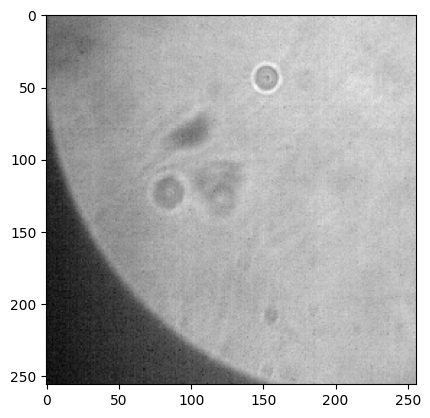

In [34]:
import matplotlib.pyplot as plt


plt.imshow(img_batch[0].cpu().squeeze(0), cmap = 'gray')

In [35]:
output = model(img_batch[0].unsqueeze(0))

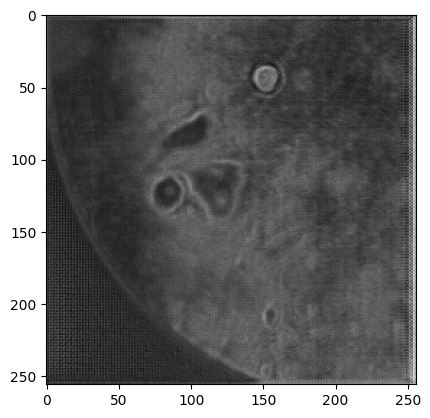

In [36]:
output_mask = np.array(output.detach().squeeze(0).squeeze(0).cpu())
plt.imshow(output_mask, cmap = 'gray')

## Save model weights

In [ ]:
torch.save(model.state_dict(), PATH)

In [29]:
model

UNet(
  (enc1): Encoder(
    (conv): ConvBlock(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): Encoder(
    (conv): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc3): Encode

model

In [34]:
#from ImageUtils import ImageUtils
from IPython.display import Image, display
#from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
#Store a random number
rnd_index = np.random.randint(len(input_img_paths))

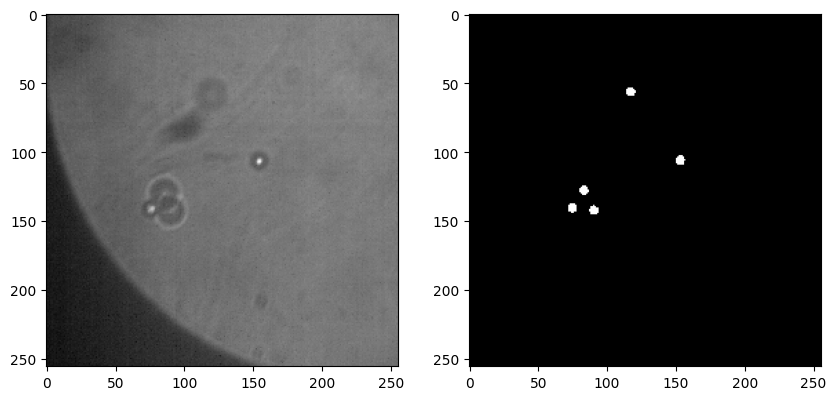

In [35]:
# Display input image
fig, ax = plt.subplots(1, 2, figsize=[10, 10])
#img_load = load_img(input_img_paths[rnd_index])
#img = normimg(cv2.resize((cv2.imread(input_img_paths[rnd_index]))[minY:maxY,minX:maxX], resized_size_dimensions))
img = cv2.resize((cv2.imread(input_img_paths[rnd_index]))[minY:maxY,minX:maxX], resized_size_dimensions)
#mask = normimg((cv2.imread(target_img_paths[rnd_index])))
mask = normimg((cv2.imread(target_img_paths[rnd_index])))
# Convert mask to binary image
threshold = 0.1  # Adjust the threshold value as needed
binary_mask = (mask > threshold).astype(float)
# Use to cv2 to normalise image from 0 to 1
# Normalize image using cv2


normalized_img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
ax[0].imshow(normalized_img, cmap='gray')
ax[1].imshow(binary_mask, cmap='gray')
plt.show()

In [36]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the desired size
    transforms.ToTensor(),  # Convert to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Apply the transformations
img_transformed = transform(img)

# Display the transformed image
img_transformed_np = img_transformed.permute(1, 2, 0).numpy()  # Convert to numpy for display
plt.imshow(img_transformed_np)
plt.axis('off')
plt.show()

TypeError: Unexpected type <class 'numpy.ndarray'>

# Evaluating on pre-loaded weights

In [30]:
model_path = "/kaggle/working/checkpoints/checkpoint_epoch_10.pth"

In [39]:
!wget /kaggle/working/checkpoints/checkpoint_epoch_13.pth

/kaggle/working/checkpoints/checkpoint_epoch_13.pth: Scheme missing.


In [31]:
model.load_state_dict(torch.load(model_path), strict = False)

_IncompatibleKeys(missing_keys=['enc1.conv.conv1.weight', 'enc1.conv.conv1.bias', 'enc1.conv.bn1.weight', 'enc1.conv.bn1.bias', 'enc1.conv.bn1.running_mean', 'enc1.conv.bn1.running_var', 'enc1.conv.conv2.weight', 'enc1.conv.conv2.bias', 'enc1.conv.bn2.weight', 'enc1.conv.bn2.bias', 'enc1.conv.bn2.running_mean', 'enc1.conv.bn2.running_var', 'enc2.conv.conv1.weight', 'enc2.conv.conv1.bias', 'enc2.conv.bn1.weight', 'enc2.conv.bn1.bias', 'enc2.conv.bn1.running_mean', 'enc2.conv.bn1.running_var', 'enc2.conv.conv2.weight', 'enc2.conv.conv2.bias', 'enc2.conv.bn2.weight', 'enc2.conv.bn2.bias', 'enc2.conv.bn2.running_mean', 'enc2.conv.bn2.running_var', 'enc3.conv.conv1.weight', 'enc3.conv.conv1.bias', 'enc3.conv.bn1.weight', 'enc3.conv.bn1.bias', 'enc3.conv.bn1.running_mean', 'enc3.conv.bn1.running_var', 'enc3.conv.conv2.weight', 'enc3.conv.conv2.bias', 'enc3.conv.bn2.weight', 'enc3.conv.bn2.bias', 'enc3.conv.bn2.running_mean', 'enc3.conv.bn2.running_var', 'enc4.conv.conv1.weight', 'enc4.conv.c